In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
RESULTS = "/Users/aag/Documents/ropt-aqc/data/raw"
PROCESSED_RESULTS = "/Users/aag/Documents/ropt-aqc/data/processed"

SIMULATION_ID = "A127566"
RAW_DATA_DIR = os.path.join(RESULTS, SIMULATION_ID)
FIDELITY_FIGURE_DIR = os.path.join(PROCESSED_RESULTS, SIMULATION_ID, "fidelity_figures")
PROCESSED_DATA_DIR = os.path.join(PROCESSED_RESULTS, SIMULATION_ID)

In [ ]:
## PXP system compressions

system = 'pxp'

In [ ]:
# set up quimb
from functools import partial
import quimb.tensor
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator

simulator_settings = QuimbSimulator(
    partial(quimb.tensor.Circuit, gate_contract="split-gate"),
    autodiff_backend="jax", 
)

# 1. AQC Forward

In [ ]:
method = 'AQC-forward'

In [ ]:
# For all methods, load paramters from json file
import json
import os

full_path = os.path.join(RAW_DATA_DIR, f"{SIMULATION_ID}.json")

with open(full_path, 'r') as f:
    result = json.load(f)

params = result['params']
num_sites, num_steps, final_time = params

original_depth_qc = result['original_depth']
initial_aqc_depth = result['initial_aqc_depth']
initial_transpiled_depth = result['initial_transpiled_depth']
elbow_N = result['elbow_N']
plateau_N = result['plateau_N']
df = result['df']
aqc_initial_parameters = result['aqc_initial_parameters']
aqc_final_parameters = result['aqc_final_parameters']
aqc_target_mpo = result['aqc_target_mpo']

In [ ]:
# Recover fidelity plot
fidlity_plot_path = os.path.join(FIDELITY_FIGURE_DIR, f"{method}_{final_time}_{system}_fidelity.pdf")
display(IFrame(fidlity_plot_path, width=700, height=500))

In [ ]:
from qiskit import qpy

aqc_path = os.path.join(RESULTS, f"aqc_ansatz_{num_sites}q_{final_time}t_{num_steps}steps_forward.qpy")

with open(aqc_path, "rb") as f:
   aqc_ansatz = qpy.load(f)[0]

In [ ]:
# Compress circuit
from ropt_aqc.comparison_methods import compress_AQC_unitary

# N_vals = [int(plateau_N)]
N_vals = [4]
df_compressed, aqc_ansatz_compressed, aqc_final_parameters_compressed = compress_AQC_unitary(aqc_ansatz, aqc_initial_parameters, aqc_target_mpo, N_vals, simulator_settings, num_steps)

In [ ]:
from qiskit import transpile

print(aqc_ansatz_compressed.depth())
transpiled_circuit_aqc = transpile(aqc_ansatz_compressed, basis_gates=['cx', 'rz', 'sx'], optimization_level=3)
print(transpiled_circuit_aqc.depth())

In [ ]:
print("=== Compressed Optimised Circuit ===")
print(aqc_ansatz_compressed.depth())
param_binding = {param: value for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed)}
aqc_optimised_compressed = aqc_ansatz_compressed.assign_parameters(param_binding)

aqc_optimised_compressed.draw("mpl")
# aqc_optimised_compressed.draw("mpl").savefig('optimised_circuit_hybrid-AQC-u_PXP.pdf')
# print(aqc_optimised_compressed.depth())

In [ ]:
print("\n=== Compressed Optimised Parameters ===")
import pandas as pd
for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed):
    print(f"{param}: {value:.6f}")

df_params = pd.DataFrame({'parameters': aqc_final_parameters_compressed})
df_params.to_csv('aqc_unitary_parameters_Ising.csv', index=False)

In [ ]:
print(f"Number of parameters in ansatz: {len(aqc_ansatz_compressed.parameters)}")
print(f"Physical depth of compressed circuit: {aqc_optimised_compressed.depth()}")
print(f"Transpiled depth of compressed circuit: {transpiled_circuit_aqc.depth()}")
print(f"Compression ratio: {initial_aqc_depth / aqc_optimised_compressed.depth()}")
print(f"Transpiled Compression ratio: {initial_transpiled_depth / transpiled_circuit_aqc.depth()}")

In [ ]:
from ropt_aqc.pxp_model import convert_qiskit_layers_to_gate_tensors, test_magnetisation_qiskit

binary = '10101010100101010101'
time_steps=10

layered_gates_compressed = convert_qiskit_layers_to_gate_tensors(aqc_optimised_compressed)
state_compressed = test_magnetisation_qiskit(num_sites, binary, time_steps, layered_gates_compressed)

# 2. AQC Reverse

In [ ]:
method = 'AQC-reverse'

In [ ]:
# For all methods, load paramters from json file
full_path = os.path.join(RAW_DATA_DIR, f"{SIMULATION_ID}.json")

with open(full_path, 'r') as f:
    result = json.load(f)

params = result['params']
num_sites, num_steps, final_time = params

original_depth_qc = result['original_depth']
initial_aqc_depth = result['initial_aqc_depth']
initial_transpiled_depth = result['initial_transpiled_depth']
elbow_N = result['elbow_N']
plateau_N = result['plateau_N']
df = result['df']
aqc_initial_parameters = result['aqc_initial_parameters']
aqc_final_parameters_reverse = result['aqc_final_parameters']
aqc_target_mpo = result['aqc_target_mpo']

In [ ]:
# For reverse methods, load truncated aqc ansatz
from qiskit import qpy

aqc_path = os.path.join(RESULTS, f"aqc_ansatz_{num_sites}q_{final_time}t_{num_steps}steps_reverse.qpy")

with open(aqc_path, "rb") as f:
   aqc_truncated = qpy.load(f)[0]


In [ ]:
from qiskit import transpile

print(aqc_truncated.depth())
transpiled_circuit_aqc = transpile(aqc_truncated, basis_gates=['cx', 'rz', 'sx'], optimization_level=3)
print(transpiled_circuit_aqc.depth())

In [ ]:
# Recover fidelity plot
fidlity_plot_path = os.path.join(FIDELITY_FIGURE_DIR, f"{method}_{final_time}_{system}_fidelity.pdf")
display(IFrame(fidlity_plot_path, width=700, height=500))

In [ ]:
print("=== Compressed Optimised Circuit ===")

param_binding = {param: value for param, value in zip(aqc_truncated.parameters, aqc_final_parameters_reverse)}
aqc_optimised_compressed = aqc_truncated.assign_parameters(param_binding)

aqc_optimised_compressed.draw("mpl")
# aqc_optimised_compressed.draw("mpl").savefig('Figures/optimised_circuit_AQC-u_PXP.pdf')

In [ ]:
print(aqc_optimised_compressed.depth())
transpiled_circuit_aqc = transpile(aqc_optimised_compressed, basis_gates=['cx', 'rz', 'sx'], optimization_level=3)
print(transpiled_circuit_aqc.depth())

In [ ]:
print("\n=== Compressed Optimised Parameters ===")
import pandas as pd
for param, value in zip(aqc_truncated.parameters, aqc_final_parameters_reverse):
    print(f"{param}: {value:.6f}")

df_params = pd.DataFrame({'parameters': aqc_final_parameters_compressed})
df_params.to_csv('aqc_unitary_parameters_Ising.csv', index=False)

In [ ]:
print(f"Number of parameters in ansatz: {len(aqc_truncated.parameters)}")
print(f"Physical depth of compressed circuit: {aqc_optimised_compressed.depth()}")
print(f"Transpiled depth of compressed circuit: {transpiled_circuit_aqc.depth()}")
print(f"Compression ratio: {initial_aqc_depth / aqc_optimised_compressed.depth()}")
print(f"Transpiled Compression ratio: {initial_transpiled_depth / transpiled_circuit_aqc.depth()}")

# 3. Hybrid Forward

In [18]:
method = 'Hybrid-forward'

In [ ]:
# For all methods, load paramters from json file
full_path = os.path.join(RAW_DATA_DIR, f"{SIMULATION_ID}.json")

with open(full_path, 'r') as f:
    result = json.load(f)

params = result['params']
num_sites, num_steps, final_time = params

original_depth_qc = result['original_depth']
initial_aqc_depth = result['initial_aqc_depth']
initial_transpiled_depth = result['initial_transpiled_depth']
elbow_N = result['elbow_N']
plateau_N = result['plateau_N']
df = result['df']
aqc_initial_parameters = result['aqc_initial_parameters']
aqc_final_parameters_reverse = result['aqc_final_parameters']
aqc_target_mpo = result['aqc_target_mpo']

In [ ]:
# Recover fidelity plot
fidlity_plot_path = os.path.join(FIDELITY_FIGURE_DIR, f"{method}_{final_time}_{system}_fidelity.pdf")
display(IFrame(fidlity_plot_path, width=700, height=500))

In [ ]:
from qiskit import qpy

aqc_path = os.path.join(RESULTS, f"aqc_ansatz_{num_sites}q_{final_time}t_{num_steps}steps_forward.qpy")

with open(aqc_path, "rb") as f:
   aqc_ansatz = qpy.load(f)[0]

In [ ]:
import pickle
with open(os.path.join(RESULTS, f"optimized_gates{num_sites}q_{num_steps}steps_{final_time}t_forward.pkl"), "rb") as f:
    gates_optimised, err_iter = pickle.load(f)


In [ ]:
import yaml

repo_root = "/Users/aag/Documents/ropt-aqc/"
config_file = os.path.join(repo_root, "run", system, "configs", "config.yml") 
with open(config_file, "r") as f:
    config = yaml.safe_load(f)

In [ ]:
# Compress circuit
from ropt_aqc.comparison_methods import compress_HS_AQC_unitary

# N_vals = [int(plateau_N)]
N_vals = [3]
df_compressed, aqc_ansatz_compressed, aqc_initial_parameters_compressed, aqc_final_parameters_compressed = compress_HS_AQC_unitary(gates_optimised, config, simulator_settings, aqc_target_mpo, N_vals)

In [ ]:
print("=== Compressed Optimised Circuit ===")
print(aqc_ansatz_compressed.depth())
param_binding = {param: value for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed)}
aqc_optimised_compressed = aqc_ansatz_compressed.assign_parameters(param_binding)

aqc_optimised_compressed.draw("mpl")
# aqc_optimised_compressed.draw("mpl").savefig('optimised_circuit_hybrid-AQC-u_PXP.pdf')
# print(aqc_optimised_compressed.depth())

In [ ]:
print("\n=== Compressed Optimised Parameters ===")
import pandas as pd
for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed):
    print(f"{param}: {value:.6f}")

df_params = pd.DataFrame({'parameters': aqc_final_parameters_compressed})
df_params.to_csv('aqc_unitary_parameters_Ising.csv', index=False)

In [ ]:
from qiskit import transpile

print(aqc_ansatz_compressed.depth())
transpiled_circuit_aqc = transpile(aqc_ansatz_compressed, basis_gates=['cx', 'rz', 'sx'], optimization_level=3)
print(transpiled_circuit_aqc.depth())

In [ ]:
print(f"Number of parameters in ansatz: {len(aqc_ansatz_compressed.parameters)}")
print(f"Physical depth of compressed circuit: {aqc_optimised_compressed.depth()}")
print(f"Transpiled depth of compressed circuit: {transpiled_circuit_aqc.depth()}")
print(f"Compression ratio: {initial_aqc_depth / aqc_optimised_compressed.depth()}")
print(f"Transpiled Compression ratio: {initial_transpiled_depth / transpiled_circuit_aqc.depth()}")

In [ ]:
layered_gates_compressed = convert_qiskit_layers_to_gate_tensors(aqc_optimised_compressed)
state_compressed = test_magnetisation_qiskit(num_sites, binary, time_steps, layered_gates_compressed)

# 4. Hybrid Reverse

In [ ]:
method = 'Hybrid-reverse'

In [ ]:
# For all methods, load paramters from json file
full_path = os.path.join(RAW_DATA_DIR, f"{SIMULATION_ID}.json")

with open(full_path, 'r') as f:
    result = json.load(f)

params = result['params']
num_sites, num_steps, final_time = params

original_depth_qc = result['original_depth']
initial_aqc_depth = result['initial_aqc_depth']
initial_transpiled_depth = result['initial_transpiled_depth']
elbow_N = result['elbow_N']
plateau_N = result['plateau_N']
df = result['df']
aqc_initial_parameters = result['aqc_initial_parameters']
aqc_final_parameters_reverse = result['aqc_final_parameters']
aqc_target_mpo = result['aqc_target_mpo']

In [ ]:
# For reverse methods, load truncated aqc ansatz
from qiskit import qpy

aqc_path = os.path.join(RESULTS, f"aqc_ansatz_hybrid_{num_sites}q_{final_time}t_{num_steps}steps_reverse.qpy")

with open(aqc_path, "rb") as f:
   aqc_truncated = qpy.load(f)[0]

In [ ]:
# Recover fidelity plot
fidlity_plot_path = os.path.join(FIDELITY_FIGURE_DIR, f"{method}_{final_time}_{system}_fidelity.pdf")
display(IFrame(fidlity_plot_path, width=700, height=500))

In [ ]:
from qiskit import transpile

print(aqc_truncated.depth())
transpiled_circuit_aqc = transpile(aqc_truncated, basis_gates=['cx', 'rz', 'sx'], optimization_level=3)
print(transpiled_circuit_aqc.depth())

In [ ]:
print("=== Compressed Optimised Circuit ===")

param_binding = {param: value for param, value in zip(aqc_truncated.parameters, aqc_final_parameters_reverse)}
aqc_optimised_compressed = aqc_truncated.assign_parameters(param_binding)

aqc_optimised_compressed.draw("mpl")
# aqc_optimised_compressed.draw("mpl").savefig('Figures/optimised_circuit_AQC-u_PXP.pdf')

In [ ]:
print(aqc_optimised_compressed.depth())
transpiled_circuit_aqc = transpile(aqc_optimised_compressed, basis_gates=['cx', 'rz', 'sx'], optimization_level=3)
print(transpiled_circuit_aqc.depth())

In [ ]:
print(f"Number of parameters in ansatz: {len(aqc_truncated.parameters)}")
print(f"Physical depth of compressed circuit: {aqc_optimised_compressed.depth()}")
print(f"Transpiled depth of compressed circuit: {transpiled_circuit_aqc.depth()}")
print(f"Compression ratio: {initial_aqc_depth / aqc_optimised_compressed.depth()}")
print(f"Transpiled Compression ratio: {initial_transpiled_depth / transpiled_circuit_aqc.depth()}")

In [ ]:
from ropt_aqc.pxp_model import convert_qiskit_layers_to_gate_tensors

layered_gates_compressed = convert_qiskit_layers_to_gate_tensors(aqc_optimised_compressed)
state_compressed = test_magnetisation_qiskit(num_sites, binary, time_steps, layered_gates_compressed)

# Forward AQC compression

In [36]:
import pandas as pd
num_sites = 20
num_steps = 3
final_time = 0.6
file_path_PXP=f'/Users/aag/Documents/ropt-aqc/PXP/results/AQC_unitary_PXP_results_{num_sites}q_{final_time}_{num_steps}steps_forward.csv'
df = pd.read_csv(file_path_PXP)
# df.to_csv(file_path_PXP, index=False, mode="a", header=False)

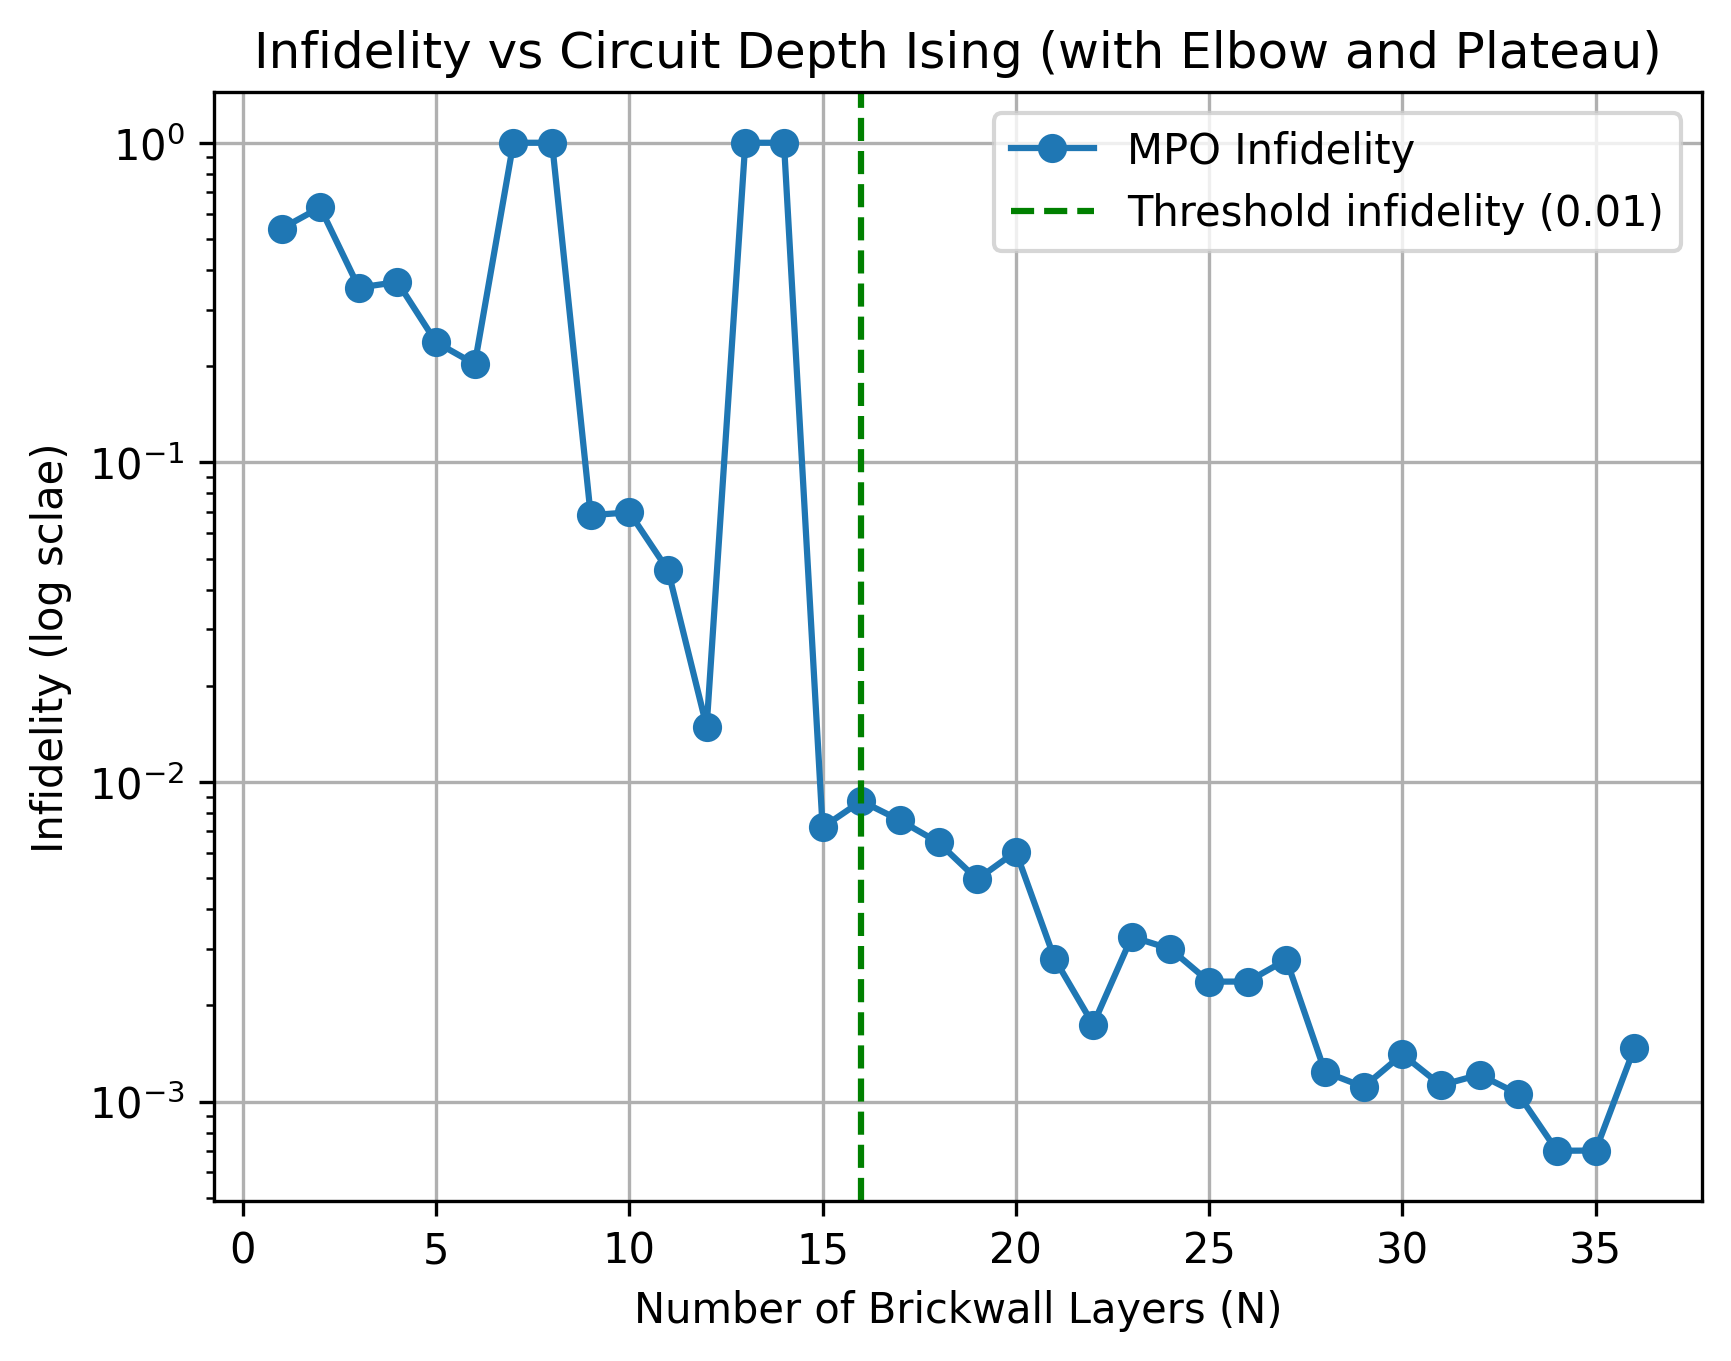


🔍 Suggested optimal compression depth: N = 16.0


In [37]:
from ropt_aqc.brickwall_opt import plot_fidelity

method = 'AQC-unitary'
elbow_N, plateau_N = plot_fidelity(df, 'Final_fidelity', final_time, 1e-2, method, 'PXP', save_path=True)

In [30]:
# Compress circuit
from ropt_aqc.comparison_methods import compress_AQC_unitary

# N_vals = [int(plateau_N)]
N_vals = [4]
df_compressed, aqc_ansatz_compressed, aqc_final_parameters_compressed = compress_AQC_unitary(aqc_ansatz, aqc_initial_parameters, aqc_target_mpo, N_vals, simulator_settings, num_steps)

NameError: name 'aqc_ansatz' is not defined

# Forward Hybrid Compression

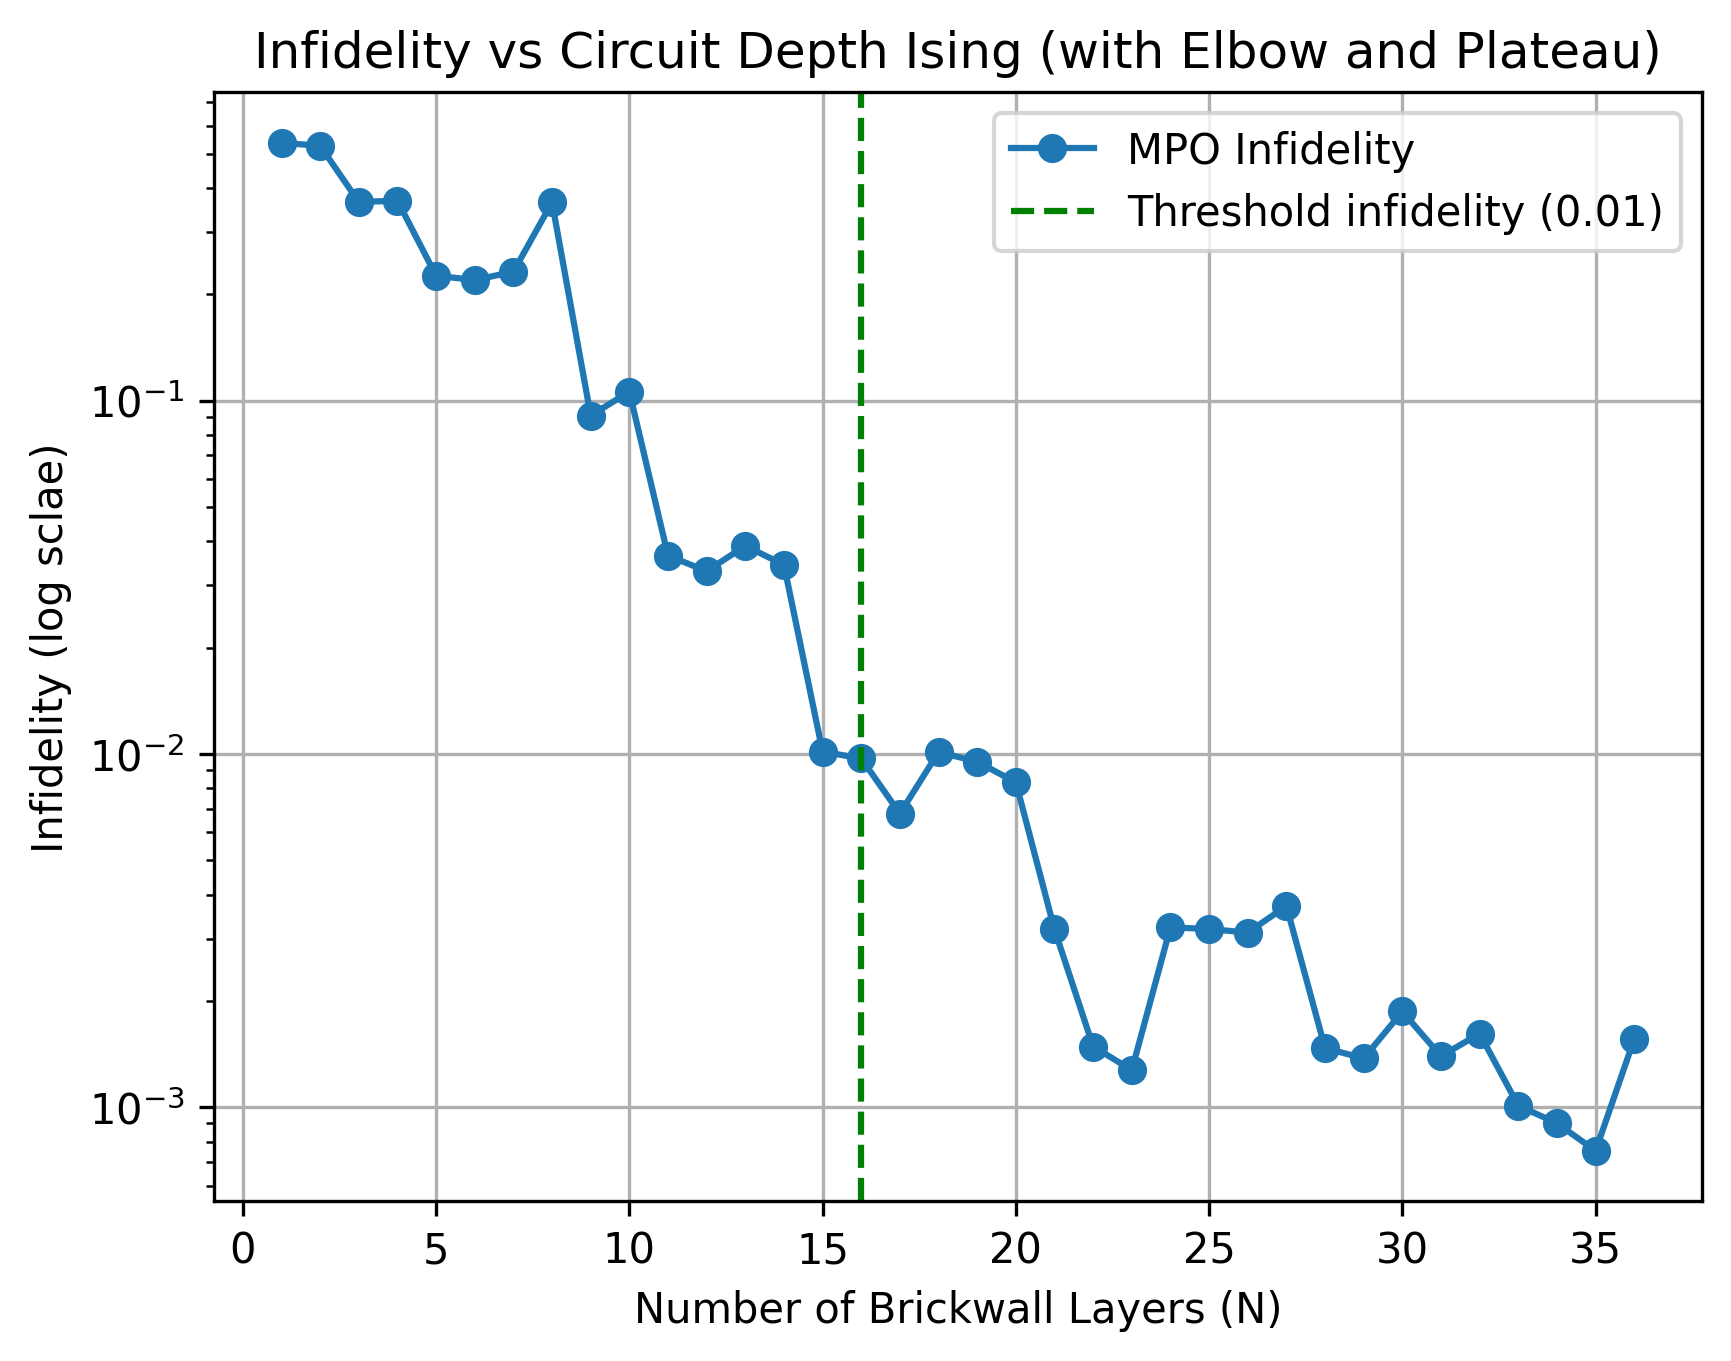


🔍 Suggested optimal compression depth: N = 16.0


In [ ]:
file_path_PXP_hybrid = f'/Users/aag/Documents/ropt-aqc/PXP/results/Hybrid_unitary_PXP_results_{num_sites}q_{final_time}_{num_steps}steps_forward.csv'
from ropt_aqc.brickwall_opt import plot_fidelity

system = 'pxp'
df =pd.read_csv(file_path_PXP_hybrid)
elbow_N, plateau_N = plot_fidelity(df, 'Final_fidelity', final_time, 1e-2, method, system, save_path=True)